[View in Colaboratory](https://colab.research.google.com/github/jimmiebtlr/ai-learning/blob/master/18.08.04.pole_cart/tutorial.ipynb)

In [0]:
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip -q install https://github.com/kmaehashi/chainer-colab/releases/download/2018-02-06/cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl
!pip -q install 'chainer==4.0.0b3'
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install chainerrl
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay


import chainer
import chainer.functions as F
import chainer.links as L
import chainerrl
import gym
import numpy as np

!apt-get install python3-numpy python3-dev python3-pip python3-wheel
!pip3 install gym numpy tflearn gym pyvirtualdisplay


Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-numpy is already the newest version (1:1.12.1-3.1ubuntu4).
python3-pip is already the newest version (9.0.1-2).
python3-wheel is already the newest version (0.29.0-2).
python3-dev is already the newest version (3.6.3-0ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

In [3]:
import gym
from gym import wrappers
import random
import numpy as np
import tflearn
from matplotlib import pyplot as plt
%matplotlib inline
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from statistics import median, mean
from collections import Counter

LR = 1e-3
env = gym.make("CartPole-v0")
env.reset()
goal_steps = 500
score_requirement = 50
initial_games = 10000

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


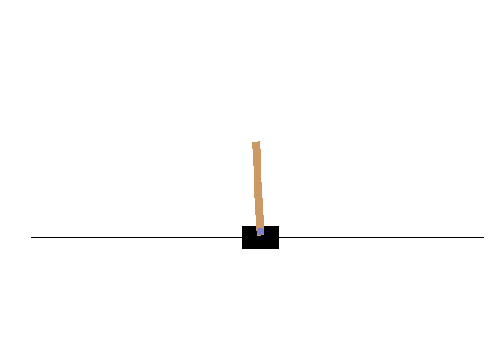

In [4]:
frames = []
def some_random_games_first():
  # Each of these is its own game.
    for episode in range(5):
        env.reset()
        # this is each frame, up to 200...but we wont make it that far.
        for t in range(200):
            # This will display the environment
            # Only display if you really want to see it.
            # Takes much longer to display it.
            frames.append(env.render(mode = 'rgb_array'))
            
            # This will just create a sample action in any environment.
            # In this environment, the action can be 0 or 1, which is left or right
            action = env.action_space.sample()
            
            # this executes the environment with an action, 
            # and returns the observation of the environment, 
            # the reward, if the env is over, and other info.
            observation, reward, done, info = env.step(action)
            if done:
                break

some_random_games_first()



import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

In [5]:
def initial_population():
    # [OBS, MOVES]
    training_data = []
    # all scores:
    scores = []
    # just the scores that met our threshold:
    accepted_scores = []
    # iterate through however many games we want:
    for _ in range(initial_games):
        score = 0
        # moves specifically from this environment:
        game_memory = []
        # previous observation that we saw
        prev_observation = []
        # for each frame in 200
        for _ in range(goal_steps):
            # choose random action (0 or 1)
            action = random.randrange(0,2)
            # do it!
            observation, reward, done, info = env.step(action)
            
            # notice that the observation is returned FROM the action
            # so we'll store the previous observation here, pairing
            # the prev observation to the action we'll take.
            if len(prev_observation) > 0 :
                game_memory.append([prev_observation, action])
            prev_observation = observation
            score+=reward
            if done: break
        
        # IMPORTANT! Not in original code
        env.reset()

        # IF our score is higher than our threshold, we'd like to save
        # every move we made
        # NOTE the reinforcement methodology here. 
        # all we're doing is reinforcing the score, we're not trying 
        # to influence the machine in any way as to HOW that score is 
        # reached.
        if score >= score_requirement:
            accepted_scores.append(score)
            for data in game_memory:
                # convert to one-hot (this is the output layer for our neural network)
                if data[1] == 1:
                    output = [0,1]
                elif data[1] == 0:
                    output = [1,0]
                    
                # saving our training data
                training_data.append([data[0], output])

        # reset env to play again
        env.reset()
        # save overall scores
        scores.append(score)
    
    # just in case you wanted to reference later
    training_data_save = np.array(training_data)
    np.save('saved.npy',training_data_save)
    
    # some stats here, to further illustrate the neural network magic!
    print('Average accepted score:',mean(accepted_scores))
    print('Median score for accepted scores:',median(accepted_scores))
    print(Counter(accepted_scores))
    
    return training_data
  

training_data = initial_population()

WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
Average accepted score: 62.06149732620321
Median score for accepted scores: 58.0
Counter({50.0: 32, 53.0: 29, 51.0: 28, 52.0: 24, 54.0: 19, 55.0: 18, 64.0: 17, 57.0: 16, 56.0: 15, 59.0: 13, 58.0: 13, 63.0: 12, 62.0: 12, 66.0: 11, 60.0: 11, 61.0: 9, 68.0: 8, 65.0: 8, 71.0: 7, 67.0: 6, 69.0: 4, 75.0: 4, 73.0: 4, 81.0: 4, 70.0: 4, 82.0: 3, 86.0: 3, 72.0: 3, 84.0: 2, 102.0: 2, 79.0: 2, 87.0: 2, 78.0: 2, 93.0: 2, 95.0: 2, 88.0: 2, 76.0: 2, 74.0: 2, 90.0: 2, 77.0: 2, 94.0: 2, 113.0: 1, 91.0: 1, 98.0: 1, 85.0: 1, 111.0: 1, 101.0: 1, 139.0: 1, 137.0: 1, 83.0: 1, 99.0: 1, 140.0: 1})


In [6]:
def neural_network_model(input_size):

    network = input_data(shape=[None, input_size, 1], name='input')

    network = fully_connected(network, 128, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 256, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 512, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 256, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 128, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 2, activation='softmax')
    network = regression(network, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')
    model = tflearn.DNN(network, tensorboard_dir='log')

    return model


def train_model(training_data, model=False):

    X = np.array([i[0] for i in training_data]).reshape(-1,len(training_data[0][0]),1)
    y = [i[1] for i in training_data]

    if not model:
        model = neural_network_model(input_size = len(X[0]))
    
    model.fit({'input': X}, {'targets': y}, n_epoch=5, snapshot_step=500, show_metric=True, run_id='openai_learning')
    return model
  
 

model = train_model(training_data)

Training Step: 1784  | total loss: 0.67818 | time: 4.146s
| Adam | epoch: 005 | loss: 0.67818 - acc: 0.5938 -- iter: 22784/22837
Training Step: 1785  | total loss: 0.67701 | time: 4.158s
| Adam | epoch: 005 | loss: 0.67701 - acc: 0.6047 -- iter: 22837/22837
--


In [7]:
scores = []
choices = []
for each_game in range(10):
    score = 0
    game_memory = []
    prev_obs = []
    env.reset()
    for _ in range(goal_steps):
        env.render()

        if len(prev_obs)==0:
            action = random.randrange(0,2)
        else:
            action = np.argmax(model.predict(prev_obs.reshape(-1,len(prev_obs),1))[0])

        choices.append(action)
                
        new_observation, reward, done, info = env.step(action)
        prev_obs = new_observation
        game_memory.append([new_observation, action])
        score+=reward
        if done: break

    scores.append(score)

print('Average Score:',sum(scores)/len(scores))
print('choice 1:{}  choice 0:{}'.format(choices.count(1)/len(choices),choices.count(0)/len(choices)))
print(score_requirement)

Average Score: 192.2
choice 1:0.5046826222684704  choice 0:0.4953173777315297
50
